# Upper Grindelwald Glacier
Get the OGGM running for the Upper Grindelwald Glacier.

## Import section

In [1]:
# standard libraries
import numpy as np
import pandas as pd
import scipy.stats as stats

# oggm modules
from oggm import utils, cfg, tasks, workflow, graphics
from oggm.core import flowline, massbalance, inversion, climate
from oggm.workflow import execute_entity_task

# data management
import netCDF4
import xarray as xr

# system libraries
import os
import shutil

# plotting libraries
import matplotlib
import matplotlib.pyplot as plt
import my_colors as mc
%matplotlib inline

## Initialize

In [2]:
# load the OGGM parameter file
cfg.initialize()

2018-07-18 11:19:07: oggm.cfg: Parameter file: /Users/oberrauch/oggm/oggm/params.cfg


In [3]:
# download and show RGI entry
df_rgi = utils.get_rgi_glacier_entities(['RGI60-11.01270'])
df_rgi

2018-07-18 11:19:14: oggm.utils: Downloading http://www.glims.org/RGI/rgi60_files/00_rgi60.zip to /Users/oberrauch/OGGM/download_cache/www.glims.org/RGI/rgi60_files/00_rgi60.zip...
100% of 413.4 MiB |######################| Elapsed Time: 0:01:23 Time:  0:01:23


,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
1269,RGI60-11.01270,G008119E46614N,20030799,20030999,8.11933,46.6143,11,1,9.023,1361,...,281,6412,0,0,0,0,9,9,None,"POLYGON ((8.127299661000052 46.63327544100008,..."


Text(8,0.5,'Latitude')

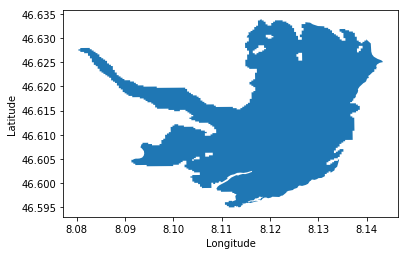

In [4]:
# plot outline
df_rgi.plot()
ax = plt.gca()
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

## Glacier directory

In [5]:
# Local working directory (where OGGM will write its output)
WORKING_DIR = os.path.join(os.getcwd(), 'grindelwald_testrun')
utils.mkdir(WORKING_DIR)
cfg.PATHS['working_dir'] = WORKING_DIR

# set climate file
cfg.PATHS['climate_file'] = os.path.join(os.getcwd(), '../raw_data/climate_monthly_histalp.nc')

In [6]:
# Here we override some of the default parameters

# User multiple flowlines
cfg.PARAMS['use_multiple_flowlines'] = True

# Use multiprocessing?
# Not usefull since I work on a single glacier
cfg.PARAMS['use_multiprocessing'] = False

# How many grid points around the glacier?
# Make it large if you expect your glaciers to grow large
cfg.PARAMS['border'] = 70

# Set to True for operational runs
# 
cfg.PARAMS['continue_on_error'] = False

# Set to True for operational runs
# Intersects are borders between glaciers
cfg.PARAMS['use_intersects'] = False


# We use intersects
# Here we use the global file but there are regional files too (faster)
cfg.set_intersects_db()

In [7]:
# Go - initialize working directories
gdirs = workflow.init_glacier_regions(df_rgi, reset=True)

# Get single glacier directory
gdir = gdirs[0]

Delete all glacier directories? [Y/n] Y


2018-04-23 14:50:20: oggm.core.gis: (RGI60-11.01270) define_glacier_region


In [8]:
# Preprocessing tasks
task_list = [
    tasks.glacier_masks,
    tasks.compute_centerlines,
    tasks.initialize_flowlines,
    tasks.compute_downstream_line,
    tasks.compute_downstream_bedshape,
    tasks.catchment_area,
    tasks.catchment_intersections,
    tasks.catchment_width_geom,
    tasks.catchment_width_correction
]
# Run all tasks
for task in task_list:
    workflow.execute_entity_task(task, gdirs)

2018-04-23 14:50:24: oggm.core.gis: (RGI60-11.01270) glacier_masks
2018-04-23 14:50:24: oggm.core.centerlines: (RGI60-11.01270) compute_centerlines
2018-04-23 14:50:24: oggm.core.centerlines: (RGI60-11.01270) initialize_flowlines
2018-04-23 14:50:24: oggm.core.centerlines: (RGI60-11.01270) compute_downstream_line
2018-04-23 14:50:25: oggm.core.centerlines: (RGI60-11.01270) compute_downstream_bedshape
2018-04-23 14:50:25: oggm.core.centerlines: (RGI60-11.01270) catchment_area
2018-04-23 14:50:28: oggm.core.centerlines: (RGI60-11.01270) catchment_intersections
2018-04-23 14:50:28: oggm.core.centerlines: (RGI60-11.01270) catchment_width_geom
2018-04-23 14:50:30: oggm.core.centerlines: (RGI60-11.01270) catchment_width_correction
2018-04-23 14:50:30: oggm.core.centerlines: (RGI60-11.01270) chosen binsize 155


## Plot some stuff

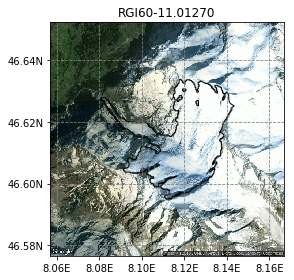

In [9]:
# Satellite image with outline
graphics.plot_googlemap(gdir)

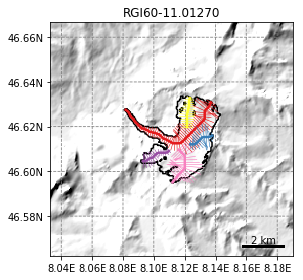

In [10]:
# plot flowlines
graphics.plot_catchment_width(gdir, corrected=True)

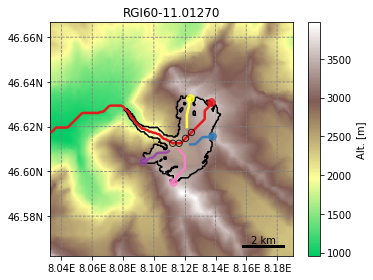

In [11]:
# plot topographic map and flowlines
graphics.plot_centerlines(gdir, use_flowlines=True, add_downstream=True)

**By the way, to which year does this glacier outline correspond?**

In [12]:
# read some rgi fields
print('RGI ID: ', gdir.rgi_id)
print('Outline from: ', gdir.rgi_date.strftime('%Y'))

RGI ID:  RGI60-11.01270
Outline from:  2003


## Now execute some preparation tasks

In [13]:
# Climate tasks -- only data IO and tstar interpolation!
execute_entity_task(tasks.process_cru_data, gdirs)
tasks.distribute_t_stars(gdirs)
execute_entity_task(tasks.apparent_mb, gdirs)

# Inversion tasks
execute_entity_task(tasks.prepare_for_inversion, gdirs)
# We use the default parameters for this run
execute_entity_task(tasks.volume_inversion, gdirs, glen_a=cfg.A, fs=0)
execute_entity_task(tasks.filter_inversion_output, gdirs)

# Final preparation for the run
execute_entity_task(tasks.init_present_time_glacier, gdirs)

2018-04-23 14:40:30: oggm.core.climate: (RGI60-11.01270) process_cru_data
2018-04-23 14:40:35: oggm.core.climate: Distribute t* and mu*
2018-04-23 14:40:35: oggm.core.climate: (RGI60-11.01270) local_mustar
2018-04-23 14:40:35: oggm.core.climate: (RGI60-11.01270) local mu* for t*=1964
2018-04-23 14:40:35: oggm.core.climate: (RGI60-11.01270) apparent_mb
2018-04-23 14:40:35: oggm.core.inversion: (RGI60-11.01270) prepare_for_inversion
2018-04-23 14:40:35: oggm.core.inversion: (RGI60-11.01270) volume_inversion
2018-04-23 14:40:35: oggm.core.inversion: (RGI60-11.01270) filter_inversion_output
2018-04-23 14:40:35: oggm.core.flowline: (RGI60-11.01270) init_present_time_glacier


## Configuration parameters

Let's read some of the configuration parameters.

@TODO: IMPORTANT: The values don't correspond with the ones used for my Bac Thesis. Therefore bias is quite high. Let's check this...

In [14]:
gdir.get_filepath('local_mustar')

'/Users/oberrauch/Documents/Studium/work/grindelwald/notebooks/grindelwald_testrun/per_glacier/RGI60-11/RGI60-11.01/RGI60-11.01270/local_mustar.csv'

In [15]:
# t*: year at which Grindelwald was in equilibrium
# mu*: temperature sensitivity
pd.read_csv(gdir.get_filepath('local_mustar'))

,rgi_id,t_star,mu_star,prcp_fac,bias
0,RGI60-11.01270,1964,241.243208,2.5,9.26617


In [16]:
# compute the local mustar
climate.local_mustar(gdir, tstar=1975, bias=0., prcp_fac=1.8)

2018-04-23 14:40:57: oggm.core.climate: (RGI60-11.01270) local_mustar
2018-04-23 14:40:57: oggm.core.climate: (RGI60-11.01270) local mu* for t*=1975


In [17]:
# t*: year at which Grindelwald was in equilibrium
# mu*: temperature sensitivity
pd.read_csv(gdir.get_filepath('local_mustar'))

,rgi_id,t_star,mu_star,prcp_fac,bias
0,RGI60-11.01270,1975,174.360612,1.8,0.0


## Topography

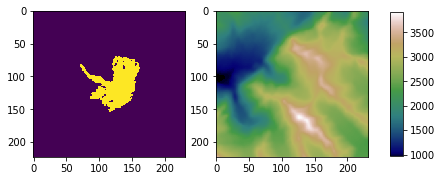

In [18]:
import matplotlib.cm as cmx

# read raster data from gdir
fgrid = gdir.get_filepath('gridded_data')
with netCDF4.Dataset(fgrid) as nc:
    topo = nc.variables['topo_smoothed'][:]
    mask = nc.variables['glacier_mask'][:]


f, (ax0, ax1) = plt.subplots(ncols=2)
# show glacier mask
ax0.imshow(mask)
# show local topography map
im_topo = ax1.imshow(topo, cmap=graphics.truncate_colormap(cmx.gist_earth))
# colorbar
cax = f.add_axes([0.95,0.25,0.03,0.5])
f.colorbar(im_topo, cax=cax)

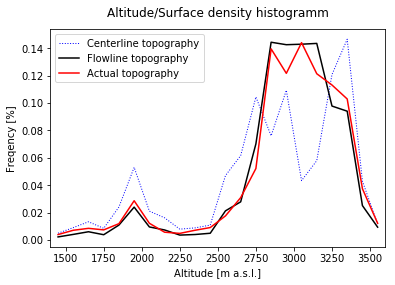

In [19]:
# histogram of real glacier
dist_bins = 100
bins = np.arange(1400, 3601, dist_bins)
bins_ = np.arange(1400+dist_bins/2, 3601-dist_bins/2, dist_bins)

# Histogram of the centerline
cl = gdir.read_pickle('inversion_flowlines')[-1]
hist_cl, _ = np.histogram(cl.surface_h, weights=cl.widths, bins=bins, density=True)

# histogram of the combined flowlines (centerline + tributaries)
surf = np.concatenate([fl.surface_h for fl in gdir.read_pickle('inversion_flowlines')])
widths = np.concatenate([fl.widths for fl in gdir.read_pickle('inversion_flowlines')])
hist, _ = np.histogram(surf, weights=widths, bins=bins, density=True)

# histogram of real glacier
dist_bins = 100
bins = np.arange(1400, 3601, dist_bins)
bins_ = np.arange(1400+dist_bins/2, 3601-dist_bins/2, dist_bins)
hist_real, _ = np.histogram(topo[np.nonzero(mask)], bins=bins, density=True)

# Plot
plt.plot(bins_, hist_cl*100, label='Centerline topography', color='b', ls=':', lw=1)
plt.plot(bins_, hist*100, label='Flowline topography', color='k')
plt.plot(bins_, hist_real*100, label='Actual topography', color='r')
plt.ylabel('Freqency [%]');
plt.xlabel('Altitude [m a.s.l.]');
plt.xlim([1400,3600])
plt.legend(loc='best');
plt.title('Altitude/Surface density histogramm', position=(0.5, 1.03));

The flowlines (centerline with tributaries) seem to be a valid representation of the glacier surface. Some statistics, no idea if the results are any meaningful...

In [32]:
# compute linear regression
reg_param = stats.linregress(hist, hist_real)
print('r value: ', reg_param[2])
# visualize
# TODO: or don't...
# plt.plot(hist, hist_real, ls='None', marker='o')

r value:  0.9865787012603163


## Mass balance data - CRU data set

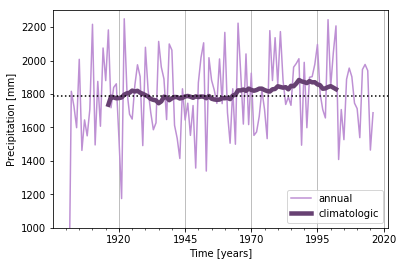

In [39]:
# read climate file
d = xr.open_dataset(gdir.get_filepath('climate_monthly'))
# compute annual precipitation
annual_prcp = d.prcp.resample(time='AS').sum().to_series()
# plot annual precipitation
ax = annual_prcp.plot(label='annual', color=mc.precip_color_1);
# compute 30 years rolling average and plot
climatol_prcp = annual_prcp.rolling(30, center=True).mean()
climatol_prcp.plot(label='climatologic', color=mc.precip_color_2, lw=4.5);

# make the plot look pretty
ax.set_ylim([1000, 2300]);
plt.axhline(annual_prcp.mean(), color='k', linestyle=':', lw=1.5)
plt.legend(loc=4);
plt.grid(axis='x')
ax.set_xlabel('Time [years]');
ax.set_ylabel('Precipitation [mm]');

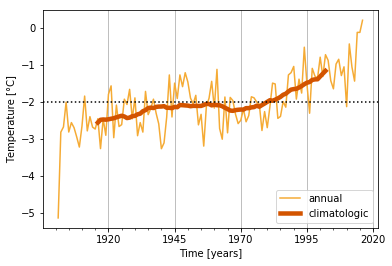

In [40]:
# compute annual mean temperature
annual_temp = d.temp.resample(time='AS').mean().to_series()
# plot annual mean temperature
ax = annual_temp.plot(label='annual',color=mc.temp_color_1);
# compute 30 years rolling average and plot
climatol_temp = annual_temp.rolling(30, center=True).mean()
climatol_temp.plot(label='climatologic', color=mc.temp_color_2, lw=4.5);

# make plot pretty(ier)
plt.legend(loc=4);
plt.grid(axis='x')
plt.axhline(annual_temp.mean(), c='k', lw=1.5, linestyle=':')
ax.set_xlabel('Time [years]');
ax.set_ylabel('Temperature [°C]');

In [41]:
# build a mass balance model
mbmod = massbalance.PastMassBalance(gdir)

# get same period
years = annual_temp.index.year.values[1:]
# create empty container
spec_mb = np.zeros(years.size)

# iterate over all years
for i, year in enumerate(years):
    # get compute annual massbalance per height band
    mb_tmp = mbmod.get_annual_mb(surf, year) * cfg.SEC_IN_YEAR
    # compute all glacier average of mass balance
    # weighted by the width of the height bands
    spec_mb[i] = np.average(mb_tmp, weights=widths)
    
# convert back into pandas Series
spec_mb = pd.Series(spec_mb, index=years)

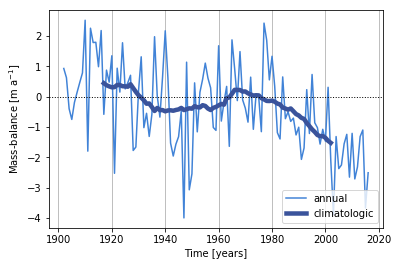

In [42]:
# plot annual mass balance
ax = spec_mb.plot(label='annual', color=mc.mb_color_1);
# compute 30 years rolling average and plot
climatol_mb = spec_mb.rolling(30, center=True).mean()
climatol_mb.plot(label='climatologic', color=mc.mb_color_2, lw=4.5);

# make plot  prettier
plt.grid(axis='x')
plt.axhline(0, linestyle=':', color='k', lw=1);
plt.legend(loc=4);
ax.set_xlabel('Time [years]');
ax.set_ylabel('Mass-balance [m a$^{-1}$]');

## Mass balance data - HISTALP

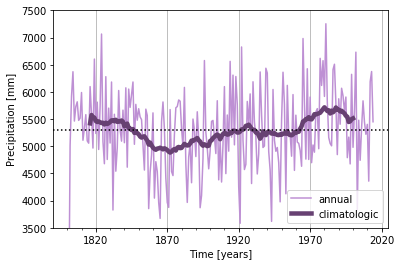

In [35]:
# read climate file
d = xr.open_dataset(cfg.PATHS['climate_file'])
# compute annual precipitation
annual_prcp = d.prcp.resample(time='AS').sum().to_series()
# plot annual precipitation
ax = annual_prcp.plot(label='annual', color=mc.precip_color_1);
# compute 30 years rolling average and plot
climatol_prcp = annual_prcp.rolling(30, center=True).mean()
climatol_prcp.plot(label='climatologic', color=mc.precip_color_2, lw=4.5);

# make the plot look pretty
ax.set_ylim([3500, 7500]);
plt.axhline(annual_prcp.mean(), color='k', linestyle=':', lw=1.5)
plt.legend(loc=4);
plt.grid(axis='x')
ax.set_xlabel('Time [years]');
ax.set_ylabel('Precipitation [mm]');

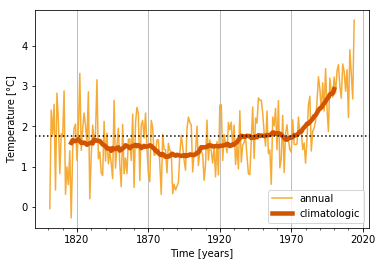

In [36]:
# compute annual mean temperature
annual_temp = d.temp.resample(time='AS').mean().to_series()
# plot annual mean temperature
ax = annual_temp.plot(label='annual',color=mc.temp_color_1);
# compute 30 years rolling average and plot
climatol_temp = annual_temp.rolling(30, center=True).mean()
climatol_temp.plot(label='climatologic', color=mc.temp_color_2, lw=4.5);

# make plot pretty(ier)
plt.legend(loc=4);
plt.grid(axis='x')
plt.axhline(annual_temp.mean(), c='k', lw=1.5, linestyle=':')
ax.set_xlabel('Time [years]');
ax.set_ylabel('Temperature [°C]');

In [37]:
# build a mass balance model
mbmod = massbalance.PastMassBalance(gdir)

# get same period
years = annual_temp.index.year.values[1:]
# create empty container
spec_mb = np.zeros(years.size)

# iterate over all years
for i, year in enumerate(years):
    # get compute annual massbalance per height band
    mb_tmp = mbmod.get_annual_mb(surf, year) * cfg.SEC_IN_YEAR
    # compute all glacier average of mass balance
    # weighted by the width of the height bands
    spec_mb[i] = np.average(mb_tmp, weights=widths)
    
# convert back into pandas Series
spec_mb = pd.Series(spec_mb, index=years)

ValueError: year 1802.0 out of the valid time bounds: [1902, 2016]

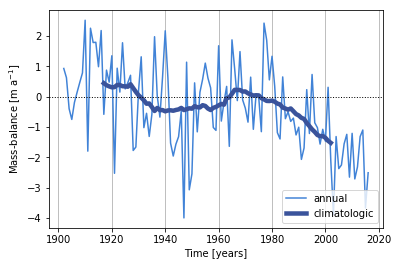

In [42]:
# plot annual mass balance
ax = spec_mb.plot(label='annual', color=mc.mb_color_1);
# compute 30 years rolling average and plot
climatol_mb = spec_mb.rolling(30, center=True).mean()
climatol_mb.plot(label='climatologic', color=mc.mb_color_2, lw=4.5);

# make plot  prettier
plt.grid(axis='x')
plt.axhline(0, linestyle=':', color='k', lw=1);
plt.legend(loc=4);
ax.set_xlabel('Time [years]');
ax.set_ylabel('Mass-balance [m a$^{-1}$]');

## Calibration data from Leclerq
This is a dataset provided by Paul Leclercq: http://folk.uio.no/paulwl/data.php.

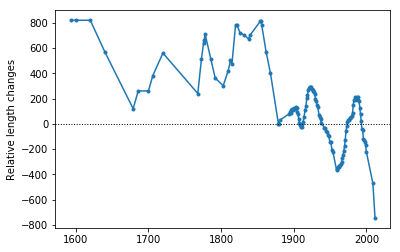

In [38]:
# read data
path = '../raw_data/grindelwald_lengths_all.csv'
length_data = pd.read_csv(path, index_col=0)

# visualize
ax = length_data.plot(marker='.', legend=False)
ax.axhline(0, ls=':', color='k', lw=1)
ax.set_xlabel('')
ax.set_ylabel('Relative length changes');

## Use Histalp climate data

In [66]:
#climate_file_path = gdir.get_filepath('climate_monthly_histalp')
climate_file_path

'/Users/oberrauch/Documents/Studium/work/grindelwald/notebooks/grindelwald_testrun/per_glacier/RGI60-11/RGI60-11.01/RGI60-11.01270/climate_monthly.nc'

In [48]:
# filepaths
climate_file_path = gdir.get_filepath('climate_monthly')
original_file_path = climate_file_path.replace('climate_monthly.nc', 'climate_monthly_orig.nc')
climate_dir_path = os.path.dirname(climate_file_path)

# manage climate files
if not os.path.exists(original_file_path):
    # copy original climate file as climate_monthly_orig.nc
    shutil.copy(climate_file_path, original_file_path);
    print('New climate file created from original...')
else:
    # delete modified file
    os.remove(climate_file_path)
    # rename original file
    os.rename(original_file_path, climate_file_path)
    # copy original climate file as climate_monthly_orig.nc
    shutil.copy(climate_file_path, original_file_path);
    print('Old climate file deleted and a new one created from original...')


New climate file created from original...


In [49]:
# open climate file
ds = xr.open_dataset(climate_file_path)
# modify precipiation
ds['prcp'] = ds.prcp / 2.5 * 1.8

# save as new climate file
if os.path.exists(climate_file_path):
    os.remove(climate_file_path)
ds.to_netcdf(climate_file_path)

In [56]:
# prepare for inversion
inversion.prepare_for_inversion(gdir)

2018-04-23 13:53:47: oggm.core.climate: (RGI60-11.01270) local_mustar
2018-04-23 13:53:47: oggm.core.climate: (RGI60-11.01270) local mu* for t*=1975
2018-04-23 13:53:47: oggm.core.inversion: (RGI60-11.01270) prepare_for_inversion
